In [1]:
import opendp.prelude as dp

In [2]:
dp.enable_features("contrib")

In [3]:
privacy_unit= dp.unit_of(contributions=1)

In [4]:
privacy_loss=dp.loss_of(epsilon=1.0)

In [5]:
# pip install urllib

In [6]:
import urllib.request
data_url="https://raw.githubusercontent.com/opendp/opendp/sydney/teacher_survey.csv"
with urllib.request.urlopen(data_url) as f:
    data=f.read().decode("utf-8")

context=dp.Context.compositor(
    data=data,
    privacy_unit=privacy_unit,
    privacy_loss=privacy_loss,
    split_evenly_over=3
)

In [7]:
col_names=[
    "names","sex","age","maritalStatus","hasChildren","highestEducationLevel","sourceOfStress","smoker","optimism","lifeSatisfaction","selfEsteem"
]

In [8]:
count_query=(
    context.query().split_dataframe(",",col_names=col_names).select_column("age",str).count().laplace()
)

In [9]:
scale=count_query.param()
print(scale)

3.0000000000000004


In [10]:
accuracy=dp.discrete_laplacian_scale_to_accuracy(scale,alpha=0.05)
accuracy

9.445721638273586

In [11]:
dp_count=count_query.release()
dp_count

6999

In [12]:
dp_count-accuracy,dp_count+accuracy

(6989.554278361727, 7008.445721638273)

In [13]:
mean_query=(
    context.query().split_dataframe(",",col_names=col_names).select_column("age",str).cast_default(float).clamp((17.0,70.0)).resize(size=dp_count,constant=42.0).mean().laplace()
)

In [14]:
mean_query.release()

37.346269479969095

# moving to another dataset

In [15]:
import urllib.request
data_url="https://raw.githubusercontent.com/opendp/opendp/sydney/Sydney_Synth_Pedestrian_Counts_2024_2_3.csv"
with urllib.request.urlopen(data_url) as f:
    data=f.read().decode("utf-8")

In [16]:
privacy_unit=dp.unit_of(contributions=3)

In [17]:
privacy_loss=dp.loss_of(epsilon=1.0)

In [18]:
col_names=["Street","Hour","First Name","Last Name","Age","Gender"]
street_names=["Park Street","Bridge Street", "Market Street"]

In [39]:
context=dp.Context.compositor(
    data=data,
    privacy_unit=privacy_unit,
    privacy_loss=privacy_loss,
    split_evenly_over=10,
)

In [24]:
Bridge_count_query=(
    context.query().split_dataframe(",",col_names=col_names).df_is_equal("Street","Bridge Street").subset_by("Street", keep_columns=["First Name"]).select_column("First Name",str).count().laplace()
)
Bridge_count_query.release()

3868

In [75]:
count_query=(
    context.query().split_dataframe(',',col_names=col_names).select_column("Street",str).count_by_categories(street_names,null_category=False).laplace()
)
street_wise_sighting=count_query.release()
street_wise_sighting

[33785, 3785, 18775]

In [31]:
hours=list(range(24))
hour_count_query=(
    context.query().split_dataframe(",",col_names=col_names).select_column("Hour",str).cast_default(int).count_by_categories(hours,null_category=False).laplace()
)
hourly_sightings= hour_count_query.release()
hourly_sightings

[1763,
 1339,
 1366,
 1178,
 646,
 279,
 369,
 711,
 995,
 1926,
 2693,
 3794,
 4365,
 4467,
 5033,
 4788,
 4907,
 4090,
 3086,
 2671,
 2055,
 1716,
 1055,
 796]

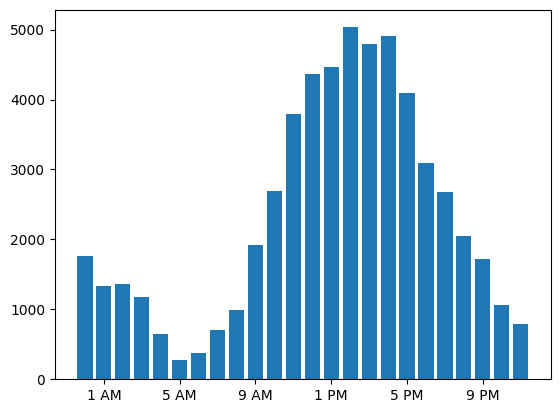

In [36]:
import matplotlib.pyplot as plt

def fmt(hour):
    return f"{int(hour)%12} {'AM' if int(hour)<12 else 'PM'}"

plt.bar(list(map(fmt,hours)),hourly_sightings)
plt.xticks(range(1,24,4))
plt.show()


In [57]:
park_street_ages=(
    context.query().split_dataframe(",",col_names=col_names).df_is_equal("Street","Park Street").select_column("Age",str).cast_default(float).clamp((0.,100.)).resize(size=street_wise_sighting[0],constant=42.0)
)

In [60]:
q_park_street_mean_ages= park_street_ages.mean().laplace()
q_park_street_mean_ages.release()

41.44563664535448

In [61]:
q_park_street_variance_ages= park_street_ages.variance().laplace()
q_park_street_variance_ages.release()

177.29181428928325

In [68]:
quantile_query=(
    context.query().split_dataframe(",",col_names=col_names).df_is_equal("Street","Park Street").subset_by("Street",keep_columns=["Age"]).select_column("Age",str).cast_default(int).quantile_score_candidates(list(range(100)),alpha=0.75).report_noisy_max_gumbel(optimize="min")

)
quantile_query.release()

53

In [77]:
quantile_query=(
    context.query().split_dataframe(",",col_names=col_names).df_is_equal("Street","Park Street").subset_by("Street",keep_columns=["First Name"]).select_column("First Name",str).count_by(M0=dp.L1Distance[int]).alp_queryable(scale=.025,total_limit=sum(street_wise_sighting),value_limit=1000)

)
# qbl=quantile_query.release()
# qbl

ValueError: At most one parameter may be missing at a time

In [ ]:
qbl("Michael"),qbl("David"),qbl("John")